In [68]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import math
import json

In [2]:
def connectLines(cp, pt1, pt2):
    mat = np.copy(cp)
    x1, y1 = pt1
    x2, y2 = pt2
    
    dx = x2-x1
    dy = y2-y1
    
    count = 0
    sx = np.sign(dx)
    sy = np.sign(dy)
    vec = [dx , dy]
    # print(vec)
    sumV = abs(dx) + abs(dy)
    ratioX = abs(vec[0]/sumV)
    ratioY = abs(vec[1]/sumV)

    while dx != 0 or dy != 0:
        r = random.random()
        # print(f"r = {r}")
        if r < ratioX and dx:
            mat[x1+dx][y1+dy] = 255
            count += 1
            dx -= sx
            # print(f"xdir: {x1+dx}")
        elif dy:
            mat[x1+dx][y1+dy] = 255
            count += 1
            dy -= sy
            # print(f"ydir {y1+dy}")
    # print(60*"*")
    # print("Final Image")
    # print(60*"*")
    # print(mat)
    # print(count)
    return mat

In [3]:
def drawLine(cp, start, end):
    arr = np.copy(cp)
    y1, x1 = start
    y2, x2 = end
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1

    if dx > dy:
        err = dx / 2.0
        while x != x2:
            arr[y][x] = 255
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            arr[y][x] = 255
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    arr[y][x] = 255
    return arr

In [4]:
def storeVals(img):
    mapping = []
    for i, row in enumerate(img):
        for j, pix in enumerate(row):
            if pix:
                mapping.append((i, j))
    return mapping


In [5]:
def pixelWipe(orig, cutoff):
    img = np.copy(orig)
    if len(img.shape) != 2:
        print("Image must be a 2D array")
        return
    else:
        for i, row in enumerate(img):
            for j, pix in enumerate(row):
                if pix and (random.random() > cutoff):
                    img[i][j] = 0
        return img
                    
                

In [96]:
def zeroPadandGetBoundingCircle(img):
    height, width = img.shape[0:2]
    maxVal = np.maximum(height+2, width+2)
    r = round(math.sqrt(2) * maxVal / 2)*2
    diffH = round(np.maximum(0, (r - width))/2)
    diffW = round(np.maximum(0, (r - height))/2)
    col = [0,0,0]
    constant= cv2.copyMakeBorder(img.copy(), diffW + 10 , diffW+10 , diffH + 10, diffH +10 ,cv2.BORDER_CONSTANT,value=col)

    return constant, r/2

In [194]:
def randShuffleMethod(cp, cutoff, l_thr, h_thr):
    cp_img = np.copy(cp)
    # plt.imshow(cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB))
    # plt.title("Original Image")
    # plt.axis(False)
    # plt.show()    
    
    edge = cv2.Canny(cp_img, l_thr, h_thr,  L2gradient = True)
    # plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    # plt.title("Canny Edge Filtered Image")
    # plt.axis(False)
    # plt.show()
    
    filt = pixelWipe(edge, cutoff)
    # plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    # plt.title("Filtered")
    # plt.axis(False)
    # plt.show()
    
    mapped = storeVals(filt)
    random.shuffle(mapped)
    
    filt1 = np.copy(filt)
    filt2 = np.copy(filt)
    for i in range(1, len(mapped)):
        filt1 = drawLine(filt1, mapped[i-1], mapped[i])
        filt2 = connectLines(filt2, mapped[i-1], mapped[i])
    # plt.imshow(cv2.cvtColor(filt1, cv2.COLOR_BGR2RGB))
    # plt.title("Str Line")
    # plt.axis(False)
    # plt.show()
    # plt.imshow(cv2.cvtColor(filt2, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line")
    # plt.axis(False)
    # plt.show()
    inv1 = cv2.bitwise_not(filt1)
    inv2 = cv2.bitwise_not(filt2)
    plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    plt.title("Random Method")
    plt.axis(False)
    plt.show()
    # plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line Inverted")
    # plt.axis(False)
    # plt.show()
    

In [195]:
def randShuffleMethodCircle(cp, cutoff, l_thr, h_thr):
    cp_img = np.copy(cp)
    # plt.imshow(cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB))
    # plt.title("Original Image")
    # plt.axis(False)
    # plt.show()    
    
    edge = cv2.Canny(cp_img, l_thr, h_thr,  L2gradient = True)
    edge, radius = zeroPadandGetBoundingCircle(edge)
    # plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    # plt.title("Canny Edge Filtered Image")
    # plt.axis(False)
    # plt.show()
    # print(f"The dims are: {edge.shape} Radius is: {radius}")
    offset = round(edge.shape[0]/2)
    
    filt = pixelWipe(edge, cutoff)
    # plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    # plt.title("Filtered")
    # plt.axis(False)
    # plt.show()
    
    mapped = storeVals(filt)
    random.shuffle(mapped)
    count =0
    filt1 = np.copy(filt)
    filt2 = np.copy(filt)
    curr = mapped[0]
    # pairs = []
    for i in range(1, len(mapped)):
        new = circle_line_intersection_center((curr), (mapped[i]), (offset, offset), radius)
        filt1 = drawLine(filt1, curr, new)
        filt2 = connectLines(filt2, curr, new)
        curr = new

#     plt.imshow(cv2.cvtColor(filt1, cv2.COLOR_BGR2RGB))
#     plt.title("Str Line")
#     plt.axis(False)
#     plt.show()

#     plt.imshow(cv2.cvtColor(filt2, cv2.COLOR_BGR2RGB))
#     plt.title("Rand Line")
#     plt.axis(False)
#     plt.show()
    
    
    
    inv1 = cv2.bitwise_not(filt1)
    inv2 = cv2.bitwise_not(filt2)
    plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    plt.title("Random Method Circle")
    plt.axis(False)
    plt.show()
    # plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line Inverted")
    # plt.axis(False)
    # plt.show()
    # with open('output.txt', 'w') as filehandle:
    #     json.dump(pairs, filehandle)

    

In [196]:
def nearMethod(cp, cut, l_thr, h_thr):
    cp_img = np.copy(cp)
    # plt.imshow(cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB))
    # plt.title("Original Image")
    # plt.axis(False)
    # plt.show()    
    
    edge = cv2.Canny(cp_img, l_thr, h_thr,  L2gradient = True)
    # plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    # plt.title("Canny Edge Filtered Image")
    # plt.axis(False)
    # plt.show()
    
    filt = pixelWipe(edge, cut)
    # plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    # plt.title("Filtered")
    # plt.axis(False)
    # plt.show()
    
    maxDist = math.dist((0,0), cp_img.shape[:-1])
    # print(distMax)
    mapped = storeVals(filt)
    
    first = random.choice(mapped)
    mapped.remove(first)
    
    filt1 = np.copy(filt)
    filt2 = np.copy(filt)
    
    while(mapped):
        second = random.choice(mapped)
        count = 0
        while (count < 500):
            if math.dist(first, second) < maxDist*0.001*count:
                break
            second = random.choice(mapped)
            count += 1

        mapped.remove(second)
        filt1 = drawLine(filt1, first, second)
        filt2 = connectLines(filt2, first, second)
        first = second
        
    
#     plt.imshow(cv2.cvtColor(filt1, cv2.COLOR_BGR2RGB))
#     plt.title("Str Line")
#     plt.axis(False)
#     plt.show()
    # plt.imshow(cv2.cvtColor(filt2, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line")
    # plt.axis(False)
    # plt.show()
    inv1 = cv2.bitwise_not(filt1)
    inv2 = cv2.bitwise_not(filt2)
    plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    plt.title("Near Method")
    plt.axis(False)
    plt.show()
    # plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line Inverted")
    # plt.axis(False)
    # plt.show()
    

In [197]:
def nearMethodCircle(cp, cut, l_thr, h_thr):
    cp_img = np.copy(cp)
    # plt.imshow(cv2.cvtColor(cp_img, cv2.COLOR_BGR2RGB))
    # plt.title("Original Image")
    # plt.axis(False)
    # plt.show()    
    
    edge = cv2.Canny(cp_img, l_thr, h_thr,  L2gradient = True)
    edge, radius = zeroPadandGetBoundingCircle(edge)
    # plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    # plt.title("Canny Edge Filtered Image")
    # plt.axis(False)
    # plt.show()
    offset = round(edge.shape[0]/2)
    
    filt = pixelWipe(edge, cut)
    # plt.imshow(cv2.cvtColor(filt, cv2.COLOR_BGR2RGB))
    # plt.title("Filtered")
    # plt.axis(False)
    # plt.show()
    
    maxDist = math.dist((0,0), cp_img.shape[:-1])
    # print(distMax)
    mapped = storeVals(filt)
    
    first = random.choice(mapped)
    mapped.remove(first)
    
    filt1 = np.copy(filt)
    filt2 = np.copy(filt)
    
    while(mapped):
        second = random.choice(mapped)
        count = 0
        while (count < 500):
            if math.dist(first, second) < maxDist*0.001*count:
                break
            second = random.choice(mapped)
            count += 1

        mapped.remove(second)
        newC = circle_line_intersection_center((first), second, (offset, offset), radius)

        
        filt1 = drawLine(filt1, first, newC)
        filt2 = connectLines(filt2, first, newC)
        first = newC
        
    
    # plt.imshow(cv2.cvtColor(filt1, cv2.COLOR_BGR2RGB))
    # plt.title("Str Line")
    # plt.axis(False)
    # plt.show()
    # plt.imshow(cv2.cvtColor(filt2, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line")
    # plt.axis(False)
    # plt.show()
    
    inv1 = cv2.bitwise_not(filt1)
    inv2 = cv2.bitwise_not(filt2)
    plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    plt.title("Near Method Circle")
    plt.axis(False)
    plt.show()
    # plt.imshow(cv2.cvtColor(inv1, cv2.COLOR_BGR2RGB))
    # plt.title("Rand Line Inverted")
    # plt.axis(False)
    # plt.show()
    

In [198]:
def circle_line_intersection_center(start_point, target_point, center_point, R, tol=1e-3):
    x1, y1 = start_point[0] - center_point[0], start_point[1] - center_point[1]
    x2, y2 = target_point[0] - center_point[0], target_point[1] - center_point[1]
    dx = x2 - x1
    dy = y2 - y1
    dr = math.sqrt(dx**2 + dy**2)
    D = x1*y2 - x2*y1
    discriminant = R**2 * dr**2 - D**2

    if discriminant < 0:
        return None # No intersection

    x_intersect_1 = (D*dy + math.copysign(1, dy) * dx * math.sqrt(discriminant)) / dr**2
    y_intersect_1 = (-D*dx + abs(dy) * math.sqrt(discriminant)) / dr**2
    x_intersect_2 = (D*dy - math.copysign(1, dy) * dx * math.sqrt(discriminant)) / dr**2
    y_intersect_2 = (-D*dx - abs(dy) * math.sqrt(discriminant)) / dr**2

    if math.hypot(x_intersect_1 - x1, y_intersect_1 - y1) > math.hypot(x_intersect_2 - x1, y_intersect_2 - y1):
        x_intersect, y_intersect = x_intersect_1, y_intersect_1
    else:
        x_intersect, y_intersect = x_intersect_2, y_intersect_2

    return (round(x_intersect + center_point[0]), round(y_intersect + center_point[1]))



In [107]:
def plot_circle_line_intersection(start_point, target_point, center_point, R):
    intersection_point = circle_line_intersection_center(start_point, target_point, center_point, R)
    print(intersection_point)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.add_artist(plt.Circle(center_point, R, fill=False))
    ax.plot([start_point[0], target_point[0]], [start_point[1], target_point[1]], 'r-')
    ax.plot(intersection_point[0], intersection_point[1], 'bo')
    ax.set_xlim(center_point[0]-R-1, center_point[0]+R+1)
    ax.set_ylim(center_point[1]-R-1, center_point[1]+R+1)
    plt.show()


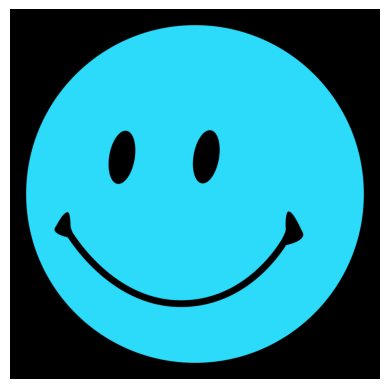

In [187]:
img = cv2.imread('./smile.png')
# img = cv2.bitwise_not(img)
plt.imshow(img)
plt.axis('off')
plt.show()

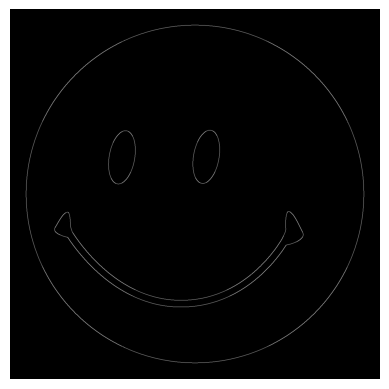

In [188]:
t_lower = 110  
t_upper = 220 

edge = cv2.Canny(img, t_lower, t_upper,  L2gradient = True)
plt.imshow(edge, cmap='gray')
plt.axis('off')
plt.show()

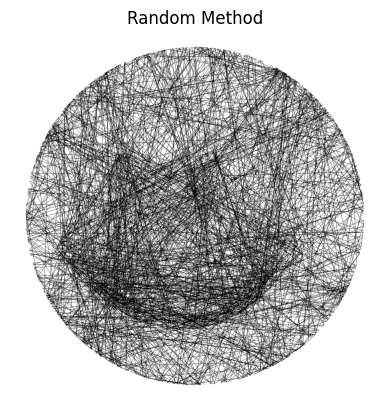

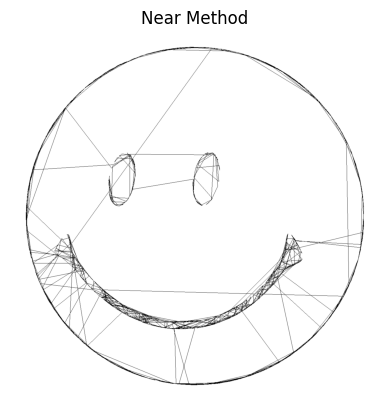

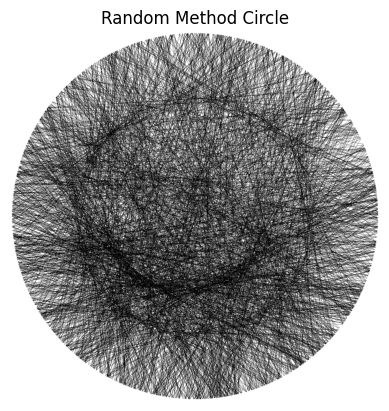

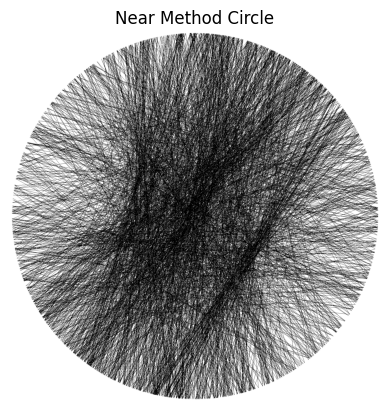

In [205]:
cutReg = 0.15
cutCirc = 0.2 
randShuffleMethod(img, cutReg, t_lower, t_upper)
nearMethod(img, cutReg, t_lower, t_upper)
randShuffleMethodCircle(img, cutCirc, t_lower, t_upper)
nearMethodCircle(img, cutCirc, t_lower, t_upper)